This notebook will detail my attempts at getting video and acoustic tracking for the speaker playbacks. This is a simple recording to handle. 

* Speaker recording: SPKRPLAYBACK_multichirp_2018-07-29_09-42-59.WAV
* Video recording : 2018-07-28/P03/K1,2,3/02000.TMC


In [1]:
import datetime as dt
import scipy.signal as signal 
import scipy.spatial as spatial
import soundfile as sf
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
print(f'Notebook cell run at {dt.datetime.now()}')

Notebook cell run at 2021-06-26 13:00:50.613129


In [3]:
import batracker
from batracker.localisation import friedlander_1987 as fr87
from batracker.localisation import schau_robinson_1987 as sr87
from batracker.localisation import spiesberger_wahlberg_2002 as sw02

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from batracker.signal_detection.detection import cross_channel_threshold_detector
from batracker.signal_detection.detection import envelope_detector
from batracker.tdoa_estimation.tdoa_estimators import measure_tdoa
from batracker.correspondence_matching.multichannel_match import generate_crosscor_boundaries

In [4]:
%matplotlib notebook

In [5]:
audiofile = 'multichirp_sankenscamerasyncoutput_2018-07-29_09-42-59.wav'
# gwt only first 2 s for now. 
audio, fs = sf.read(audiofile, stop=int(192000*7.5))

In [6]:
# get all audio that start from frame 1 of the camera sync signal (1st frame that is +ve)
first_frame_sample = np.min(np.argwhere(audio[:,-1]>=np.percentile(audio[:,-1],95)))
# audio sync'ed with 1st camera frame
cam_audio = audio[first_frame_sample:,:]

print(first_frame_sample/fs)
# get the array audio 
array_audio = cam_audio[:,:4]


1.2398802083333333


In [7]:
b,a = signal.butter(1,np.array([40e3,95e3])/(fs*.5),'bandpass')
array_audiohp = np.apply_along_axis(lambda X: signal.filtfilt(b,a,X),0,array_audio)

<IPython.core.display.Javascript object>


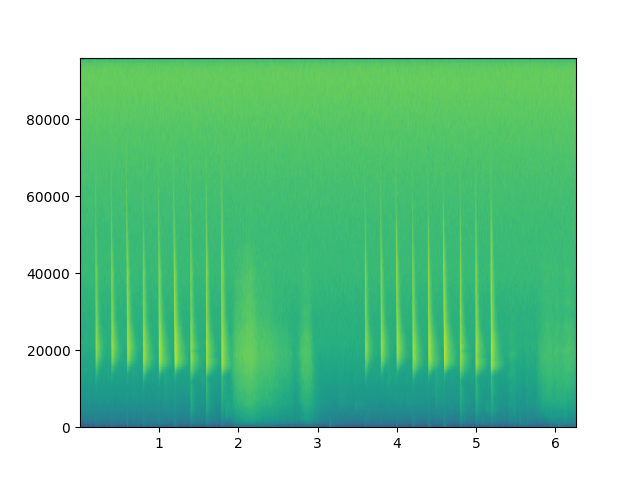

In [8]:
plt.figure()
plt.specgram(array_audiohp[:,0],Fs=fs);

In [9]:
detections = cross_channel_threshold_detector(array_audiohp, fs,
                                              detector_function=envelope_detector,
                                              threshold_db_floor=12,
                                              lowpass_durn=0.004)
# for now just use manual detections to generate the correlation boundaries

              
    
            

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

4 1201943


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.34it/s]


<IPython.core.display.Javascript object>


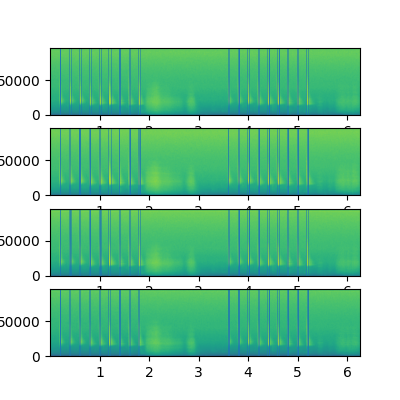

In [10]:
                                    
# Spectrogram of the cross-corr boundaries
plt.figure(figsize=(4,4))
ax= plt.subplot(411)
plt.specgram(array_audiohp[:,0], Fs=fs)
for each in detections[0]:
    plt.vlines(each, 0, fs*0.5, linewidth=0.4)

for i in range(2,5):
    plt.subplot(410+i, sharex=ax)
    plt.specgram(array_audiohp[:,i-1], Fs=fs)
    for each in detections[i-1]:
        plt.vlines(each, 0, fs*0.5, linewidth=0.4)

In [11]:

crosscor_boundaries = [(0.19,0.205),(0.387,0.402), (0.576,0.602),
                        (0.79,0.8), (0.985,1.0), (1.175, 1.2),
                       (1.39, 1.399), (1.585, 1.595), (1.774, 1.794)]    

In [12]:
# Array geometry
## What we expect it to be theoretically
R = 1.2 # meters
theta = np.pi/3
other_x_position = 0.5
theta2 = np.arctan(other_x_position/(R*np.cos(theta)))
R_2 = np.sqrt(other_x_position**2 +  (R*np.cos(theta))**2)
arbit_y = 10e-4
mic_positions = np.array([[0,arbit_y,0],
                          [R_2*np.sin(theta2),  arbit_y, -R*np.cos(theta), ],
                          [-R*np.sin(theta), arbit_y, -R*np.cos(theta)],
                          [0,arbit_y,R]])

ag = pd.DataFrame(mic_positions)
ag.columns  = ['x','y','z']

In [13]:
reference_ch = 0

all_tdoas = {}
for i,each_common in enumerate(crosscor_boundaries):
    start, stop = each_common
    start_sample, stop_sample = int(start*fs), int(stop*fs)
    tdoas = measure_tdoa(array_audiohp[start_sample:stop_sample,:], fs, ref_channel=reference_ch)
    all_tdoas[i] = tdoas

In [14]:
all_tdoas

{0: array([-0.00139583,  0.00063542,  0.00079167]),
 1: array([-0.00139583,  0.00063542,  0.00079167]),
 2: array([-0.00139844,  0.00063281,  0.00078906]),
 3: array([-0.00139583,  0.00063542,  0.00079167]),
 4: array([-0.00139583,  0.00063542,  0.00079167]),
 5: array([-0.00139583,  0.00063542,  0.00079167]),
 6: array([-0.00139583,  0.00063542,  0.00079167]),
 7: array([-0.00140104,  0.00063542,  0.00079167]),
 8: array([-0.00139583,  0.00063542,  0.00079687])}

In [15]:
vsound = 340.0
all_positions = []
num_rows = mic_positions.shape[0]-1
calculated_positions = np.zeros((len(all_tdoas.keys()), 3,2))
for det_number, tdoas in all_tdoas.items():
        d = (vsound*tdoas).reshape(-1,1)
        solution1, solution2 = sw02.spiesberger_wahlberg_solution(mic_positions, d)
        calculated_positions[det_number,:,0] = solution1
        calculated_positions[det_number,:,1] = solution2
        #calculated_positions[det_number,:] = pos    

In [16]:
valid_positions = calculated_positions[:,:,0]
valid_positions

array([[-3.00781225,  4.79623797,  1.90570181],
       [-3.00781225,  4.79623797,  1.90570181],
       [-2.97772102,  4.73816446,  1.88634926],
       [-3.00781225,  4.79623797,  1.90570181],
       [-3.00781225,  4.79623797,  1.90570181],
       [-3.00781225,  4.79623797,  1.90570181],
       [-3.00781225,  4.79623797,  1.90570181],
       [-2.98590666,  4.73454723,  1.89113058],
       [-3.02735007,  4.83097694,  1.92392102]])

### Distance of positions from central microphone - acoustic tracking 



In [17]:
mic_positions[0,:]

array([0.   , 0.001, 0.   ])

In [18]:

def calc_dist_to_m0(X, refpos):
    try:
        distance = spatial.distance.euclidean(X,refpos)
    except ValueError:
        distance = np.nan
    return distance
dist_to_mic0 = np.apply_along_axis(calc_dist_to_m0,1,valid_positions,mic_positions[0,:])
dist_to_mic0

array([5.97268291, 5.97268291, 5.90473227, 5.97268291, 5.97268291,
       5.97268291, 5.97268291, 5.90749379, 6.01622787])

In [19]:
print(np.mean(dist_to_mic0), np.std(dist_to_mic0))

5.962727930309971 0.03311790419366706


Another way to estimate distance from speaker to mic0 is to utilise the digital copy of the playback signal. We can then estimate the time of flight of the playback. 

<IPython.core.display.Javascript object>


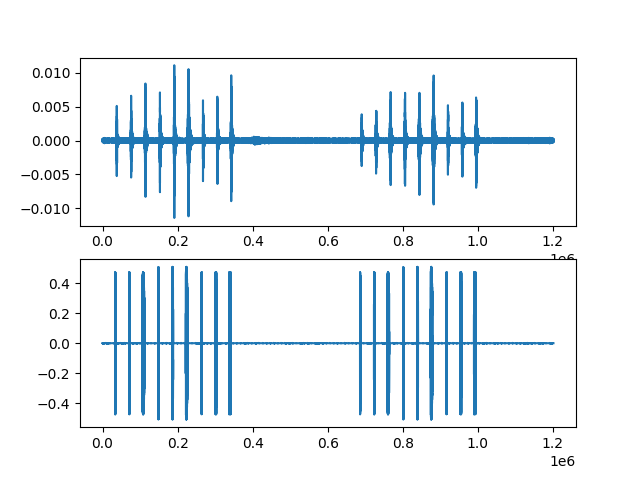

In [20]:
# crosscorrelate the output signal with channel 0. 
output_ch = cam_audio[:,-2]
plt.figure()
a0 = plt.subplot(211)
plt.plot(array_audiohp[:,0])
plt.subplot(212,sharex=a0)
plt.plot(output_ch)

In [21]:

ind_forcc = [30000, 80000]
cc = signal.correlate(array_audiohp[ind_forcc[0]:ind_forcc[1],0], cam_audio[ind_forcc[0]:ind_forcc[1],-2],'same')
delay = (np.argmax(cc)-cc.size/2.0)/fs
delay

0.017666666666666667

### Getting mic0-speaker distance through the time of flight

In [22]:
print(f'The sync-channel delay based mic0-speaker distance is {delay*340.0} m')

The sync-channel delay based mic0-speaker distance is 6.006666666666667 m


### Distance of positions from central mic - video tracking

In [23]:
# get video tracked speaker positions
speaker_posns = pd.read_csv('video_tracking/speaker_pbks/DLTdv7_data_2018-07-28_p03_2000_spkr_pbksxyzpts.csv')
speaker_posns.columns = ['x','y','z']
speaker_posns = speaker_posns[~pd.isna(speaker_posns['x'])]
speaker_posns

,x,y,z
0,0.008015,2.229281,-0.078225
62,0.420424,2.148869,-0.162072
124,0.645528,2.175114,-1.026141
187,0.400062,1.887525,0.549685
249,-0.189985,1.400496,0.825609
312,-0.616268,1.152299,0.868576
374,-1.254743,0.820054,0.728765
479,-1.910361,0.170450,-0.037294


In [24]:
video_mic_positions = pd.read_csv('video_tracking/mic_positions_video/DLTdv7_data_mics9-12positionsxyzpts.csv')
mic_xyz = video_mic_positions[~pd.isna(video_mic_positions['pt1_X'])].reset_index(drop=True)
mic_xyz.columns=['x','y','z']
mic_xyz

,x,y,z
0,-0.162229,-3.854878,0.097387
1,-1.084803,-3.256231,-0.437829
2,0.278436,-4.036286,-0.544380
3,-0.118366,-3.985202,1.299513


The first speaker position in the video corresponds to the set of first playbacks (first 9 detections). Let's see the mic0 to speaker distance estimated here. 

### Camera based m0-speaker distance

In [25]:
video_dist_to_mic0 = spatial.distance.euclidean(mic_xyz.loc[0].tolist(),speaker_posns.loc[0].tolist())
video_dist_to_mic0

6.089073273607487

## Conclusion : it's not all crap - acoustic tracking and video tracking do work together and give ~consistent results!

* The camera based m0-speaker estimate is 6.08m
* Acoustic tracking based m0-speaker estimate is 5.96 $\pm$ 0.03 m (mean, sd)
    * The time-of-flight based m0-speaker estimate is 6.0 m

### Important lessons

* Audio processing is *very* important - the reverberation below 40 kHz made a *huge* difference on the TOADs estimated. Choosing the correct bandpass parameters made all of the difference.

### Next steps

* Now I'd like to push the same exercise to more playback positions, and finally then get to aligning the audio and video tracking systems into a common system. 
* The ```batracker``` detection routines need some tuning!

In [26]:
print(f'Notebook cell run at {dt.datetime.now()}')

Notebook cell run at 2021-06-26 13:00:56.402670
